In [1]:
import pandas as pd
import numpy as np
import scipy as scp
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import sklearn 
from sklearn.preprocessing import Imputer
from sklearn import preprocessing
import statsmodels.api as sm
import xgboost as xgb

%matplotlib inline
matplotlib.style.use('ggplot')
py.init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
train = pd.read_csv('./data/Sber Bank/train.csv')
macro = pd.read_csv('./data/Sber Bank/macro.csv')
train = pd.merge(train, macro, on='timestamp')

In [3]:
train['timestamp'] = pd.to_datetime(train['timestamp'])

train.ix[train.full_sq <= 6, 'full_sq'] = np.nan
train.ix[train.life_sq <= 6, 'life_sq'] = np.nan

train.ix[train.full_sq > 2000, 'full_sq'] = np.nan
train.ix[train.life_sq > 2000, 'life_sq'] = np.nan

bad_index = [13117]
train.ix[bad_index, 'build_year'] = train.ix[bad_index, 'kitch_sq']
train.ix[bad_index, 'kitch_sq'] = np.nan

bad_index = [10368, 11520, 13117, 21415, 28734]
train.ix[bad_index, 'kitch_sq'] = np.nan

bad_index = train.ix[(train.num_room>=6) & (train.full_sq<100)].index
train.ix[bad_index, 'num_room'] = np.nan

bad_index = train.kitch_sq > train.life_sq
train.ix[bad_index, 'kitch_sq'] = np.nan

bad_index = train.kitch_sq > train.full_sq
train.ix[bad_index, 'kitch_sq'] = np.nan

bad_index = train.life_sq > train.full_sq
train.ix[bad_index, 'life_sq'] = np.nan

bad_index = train.floor > train.max_floor
train.ix[bad_index, 'floor'] = np.nan

train.ix[train.state > 30, 'state'] = np.nan

train.ix[train.ecology=='no data', 'ecology'] = np.nan

train.timestamp = pd.to_datetime(train.timestamp)
bad_index = (train.build_year == 0)
train.ix[bad_index, 'build_year'] = train.ix[bad_index].timestamp.dt.year
bad_index = (train.build_year == 1)
train.ix[bad_index, 'build_year'] = train.ix[bad_index].timestamp.dt.year-1
bad_index = (train.build_year == 3)
train.ix[bad_index, 'build_year'] = train.ix[bad_index].timestamp.dt.year-3
train.ix[train.build_year < 1600, 'build_year'] = np.nan
train.ix[train.build_year > 2018, 'build_year'] = np.nan

In [4]:
train['age'] = train['timestamp'].dt.year - train['build_year']

train['price_per_sq'] = train['price_doc']/train['full_sq']

train.ix[train.price_per_sq > 6e5, 'price_per_sq'] = np.nan

df = train.groupby('sub_area')['price_per_sq'].mean().reset_index()
df = df.rename(columns={'price_per_sq':'price_per_sq_sub_area'})
train = train.merge(df, on='sub_area')

## Region

Maybe the first and major factor in determining a house price is the region located in. In the figure below that could be seen that, the average per squared of houses encompasses a wide range from 20000 RUB in **`Poselenie Klenovekoe`** to more than 250000 RUB in **`Hamovniki`**. Notice that here per squared price (total price per total house area) is used instead of total house price to not considering the effect of total house area. 

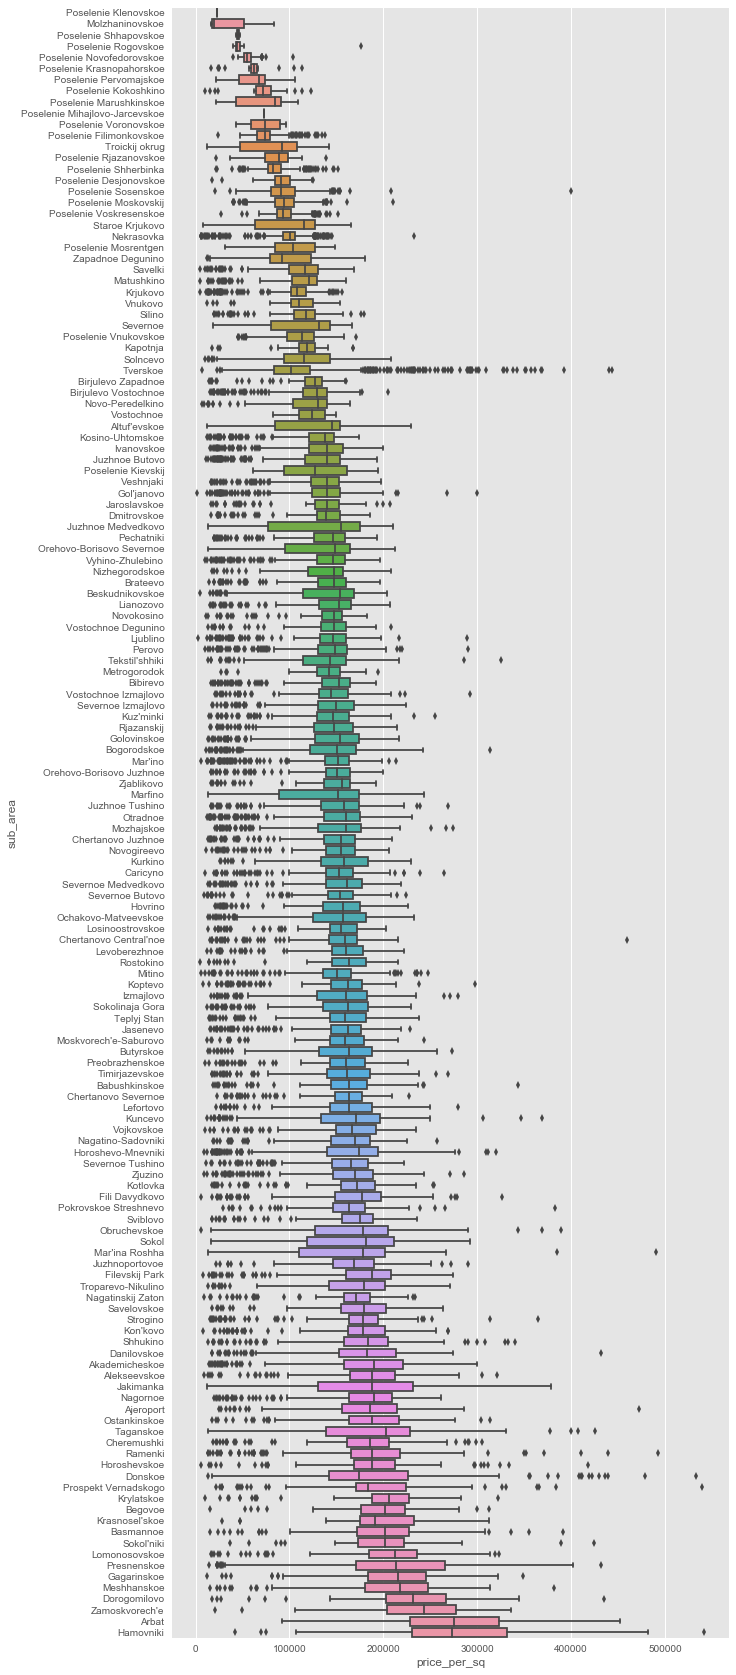

In [300]:
df = train[['sub_area', 'price_per_sq_sub_area', 'price_per_sq']].sort_values(by='price_per_sq_sub_area')

fig, ax = plt.subplots(figsize=[10,30])

sns.boxplot(df['price_per_sq'], df['sub_area'])

## House Characteristics



### State

Naturally that's expected for houses with better condition to have hogher prices. That could be clearly seen in the figure below. The average per squared house price for the best conditioned apartement is more than 175000 RUB, however this value for worst stated house is less than 125000 RUB.

There is another thing that must be noted in the figure that, the number fo house that dealed is much lower than other types. Despite more 5500 house are dealt for house with the states of 1-3, however, less than 500 transactions are recorded for state-4 houses. That might be related to their much higher costs in comaprison with the economic situation of people.

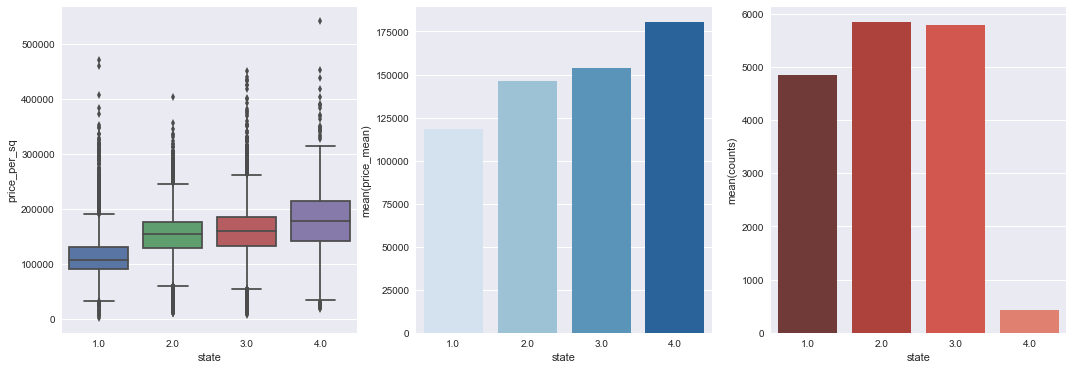

In [232]:
fig, ax = plt.subplots(1,3,figsize=[18,6])

df1 = train.groupby('state')[['price_per_sq']].size().reset_index().rename(columns={0:'counts'})
df2 = train.groupby('state')[['price_per_sq']].mean().reset_index().rename(columns={'price_per_sq':'price_mean'})
df = pd.merge(df1, df2, on='state')

sns.boxplot(train['state'], train['price_per_sq'], ax=ax[0])
sns.barplot(x='state', y='price_mean', data=df, palette='Blues', ax=ax[1])
sns.barplot(x='state', y='counts', data=df, palette='Reds_d', ax=ax[2])

### AGE

We expect for older houses to have lower per squared house. However, if they are located in higher level regions, then this assupmtion is not true. From the figures, the regression line shows that generally, the older houses have higher prices. On the other hand, we can divide each per squared house price to the average per squared prices of the houses in that region, and we name it the **region price ratio**. This parameter tries to compensate the effect of the region in house price. Now the second figure shows that the region price ratio is not effected by the age of the houses.

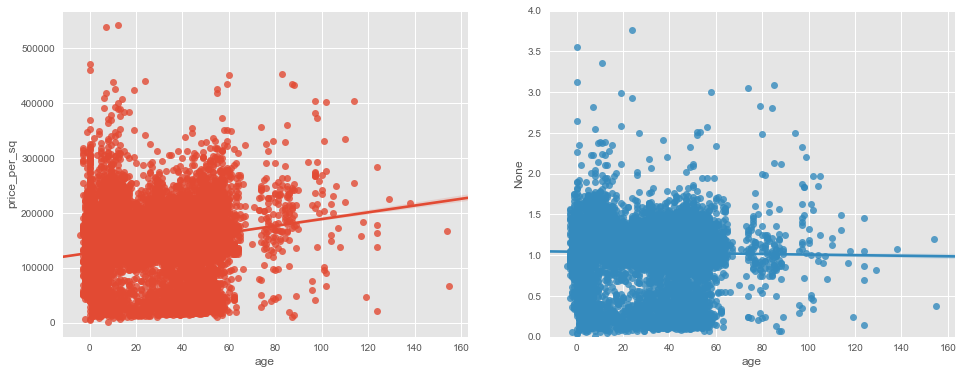

In [308]:
fig, ax = plt.subplots(1,2,figsize=[16,6])

df = train[['age', 'full_sq', 'price_per_sq', 'price_doc', 'price_per_sq_sub_area']]
df[df.age>300] = np.nan

sns.regplot(df['age'], df['price_per_sq'], ax=ax[0])

sns.regplot(df['age'], df['price_per_sq']/df['price_per_sq_sub_area'], ax=ax[1])
_ = ax[1].set_ylim(0,4)

### Floor

In general view we can state that the houses in higher floors are more expensive by average. This is what many times heared in real-estate.

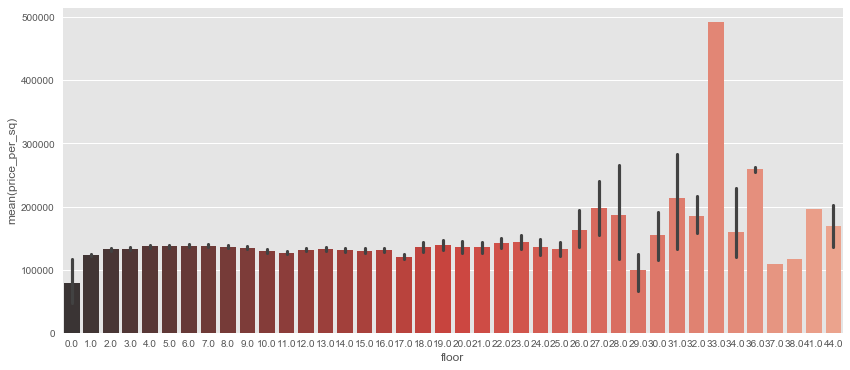

In [327]:
fig, ax = plt.subplots(figsize=[14,6])
sns.barplot(train['floor'], train['price_per_sq'], palette='Reds_d')

### Apartement Height



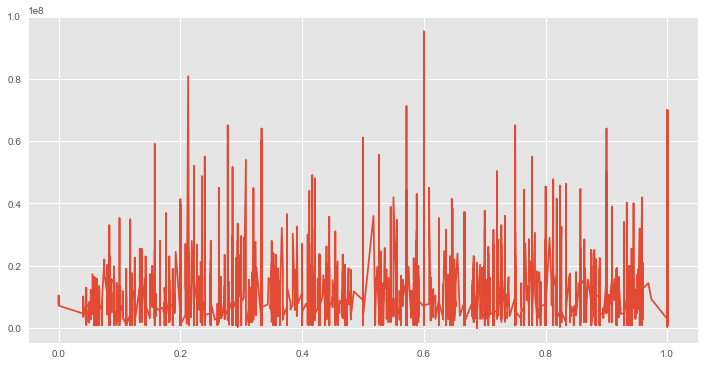

In [335]:
df = train[['floor', 'max_floor', 'price_doc']]
df['floor_ratio'] = df.floor/df.max_floor
df = df.sort_values(by='floor_ratio')
fig, ax = plt.subplots(figsize=[12,6])
plt.plot(df.floor_ratio, df['price_doc'])

### Wall Material

There is no enough information on the meaning of different Wall Material's type. However we can see some  differences between them. The most notable thing that could be seen is that, most of the houses (more than 50%) are made by the wall material type-1.

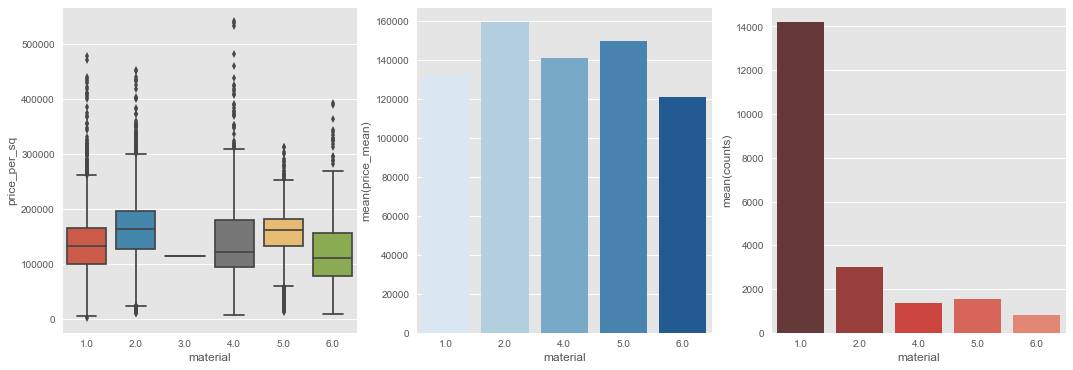

In [341]:
fig, ax = plt.subplots(1,3,figsize=[18,6])


df1 = train.groupby('material')[['price_per_sq']].size().reset_index().rename(columns={0:'counts'})
df2 = train.groupby('material')[['price_per_sq']].mean().reset_index().rename(columns={'price_per_sq':'price_mean'})
df = pd.merge(df1, df2, on='material')

sns.boxplot(train['material'], train['price_per_sq'], ax=ax[0])
sns.barplot(x='material', y='price_mean', data=df, palette='Blues', ax=ax[1])
sns.barplot(x='material', y='counts', data=df, palette='Reds_d', ax=ax[2])

### Product type

On the view point of **`Product type`** (**_Investment_** or **_Owner Occupier_**), it's concluded that, the investment type houses are more expensive (15% more) and dealt more (30% more).

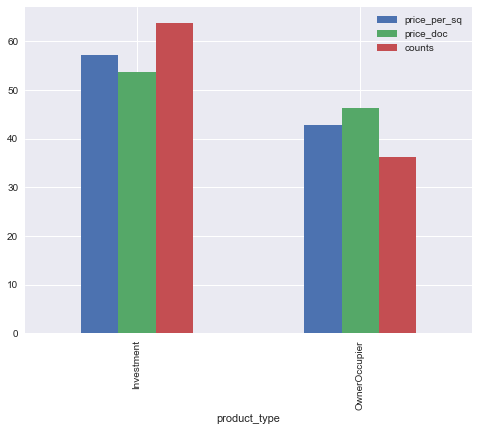

In [415]:
fig, ax = plt.subplots(figsize=[8,6])
df = train[['product_type', 'price_per_sq', 'price_doc']].groupby('product_type').mean()
df['counts'] = (train[['product_type', 'price_per_sq']].groupby('product_type').size())
df = df/df.sum() * 100
df.plot(kind='bar', ax=ax)

## Shopping Center

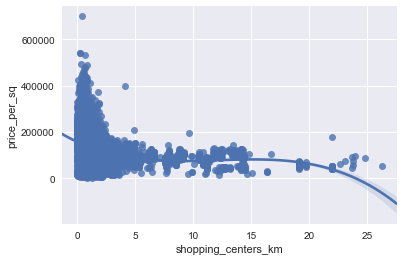

In [425]:
sns.regplot(train['shopping_centers_km'], train['price_per_sq'], order=3)

## demographic

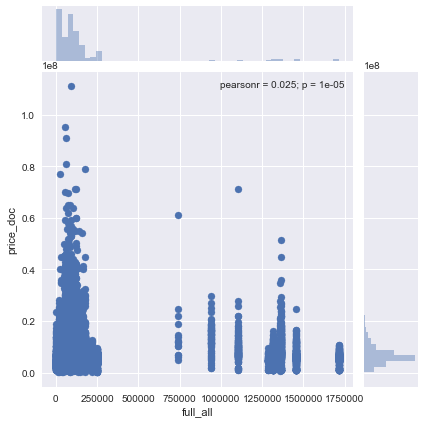

In [427]:
sns.jointplot(train['full_all'], train['price_doc'])

## Culture

From the figure below, maybe it's better to say the mosques are built in higher prices region by average. Also, it could be said that the houses nearer to mosques are more valueable averagely.

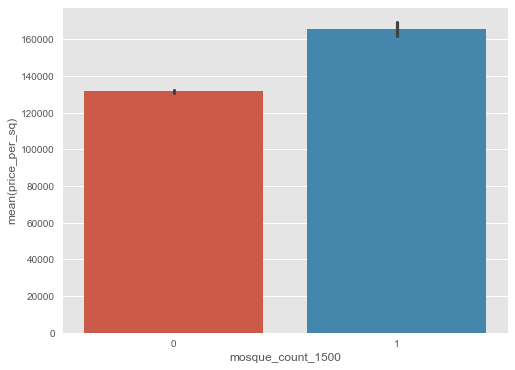

In [6]:
fig, ax = plt.subplots(figsize=[8,6])
sns.barplot(train['mosque_count_1500'], train['price_per_sq'])

Being near the curches has not a notable proficiency, but also has a slightly contrary effect.

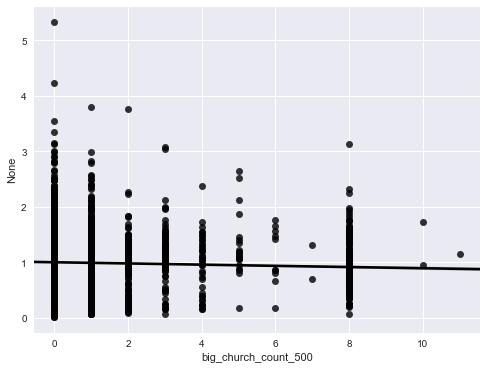

In [472]:
fig, ax = plt.subplots(figsize=[8,6])
sns.regplot(train['big_church_count_500'], train['price_per_sq']/train['price_per_sq_sub_area'], color='black')

## Industry

### Nuclear Reactor

Although the the figure shows about 10% higher prices for houses nearer to Nuclear Reactor, Thermal Power plant, but we must notice that these are less than 10% of all the cases.

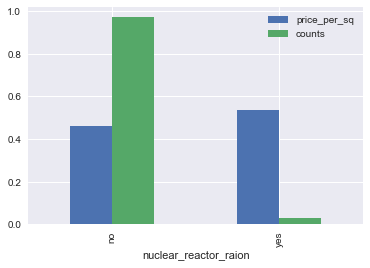

In [491]:
df = train[['nuclear_reactor_raion', 'price_per_sq']].groupby('nuclear_reactor_raion').mean()
df['counts'] = train[['nuclear_reactor_raion', 'price_per_sq']].groupby('nuclear_reactor_raion').size()
df = df/df.sum()
df.plot(kind='bar')

### Thermal Power Plant

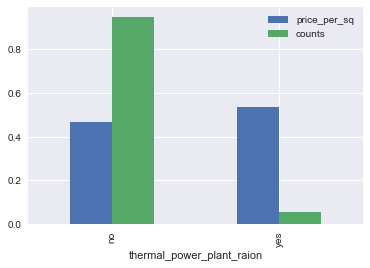

In [492]:
df = train[['thermal_power_plant_raion', 'price_per_sq']].groupby('thermal_power_plant_raion').mean()
df['counts'] = train[['thermal_power_plant_raion', 'price_per_sq']].groupby('thermal_power_plant_raion').size()
df = df/df.sum()
df.plot(kind='bar')

### Incineration

The houses nearer the Incinerations are chipper naturally, also they include around 10% of the whole Market.

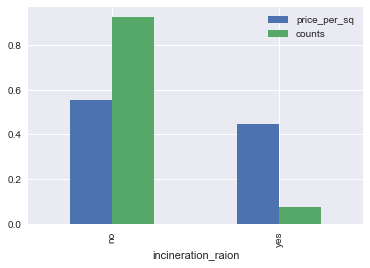

In [494]:
df = train[['incineration_raion', 'price_per_sq']].groupby('incineration_raion').mean()
df['counts'] = train[['incineration_raion', 'price_per_sq']].groupby('incineration_raion').size()
df = df/df.sum()
df.plot(kind='bar')

### Power Transmission Line

The regression line in the figure below has a negative slope that means, the closer to the Power Transmission Lines the lower house prices.

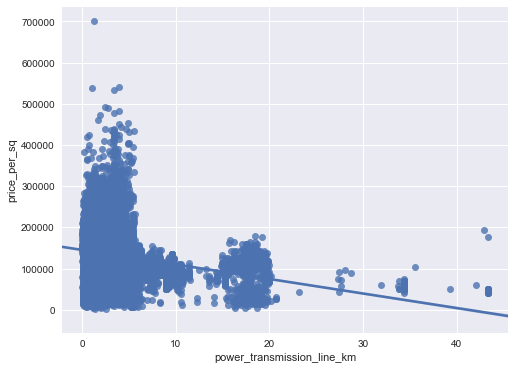

In [493]:
fig, ax = plt.subplots(figsize=[8,6])
sns.regplot(train['power_transmission_line_km'], train['price_per_sq'])

## Transportation

In general there is an obviouse effect that being near the Transportation facilities is benefit. It could be seen that the houses closer to TTRs, Subways, etc, are more expensive. These are shown in the figures below.

### Moscow Circle Auto Road

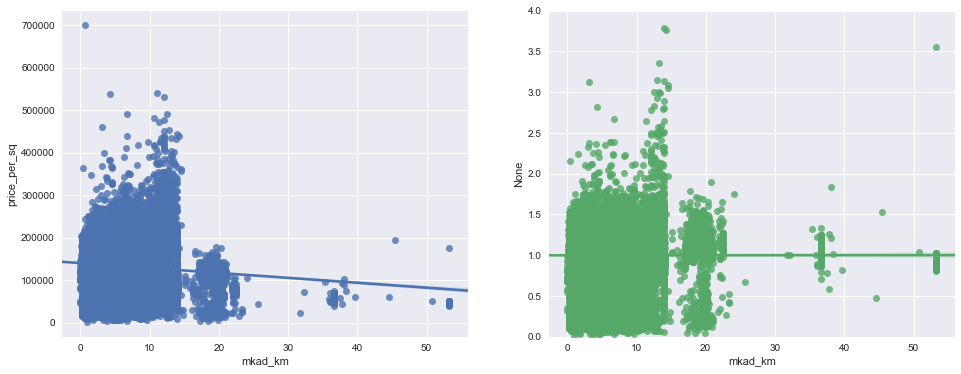

In [503]:
fig, ax = plt.subplots(1,2,figsize=[16,6])
sns.regplot(train['mkad_km'], train['price_per_sq'], ax=ax[0])
sns.regplot(train['mkad_km'], train['price_per_sq']/train['price_per_sq_sub_area'], ax=ax[1])
_ = ax[1].set_ylim(0,4)

### Third Transport Ring

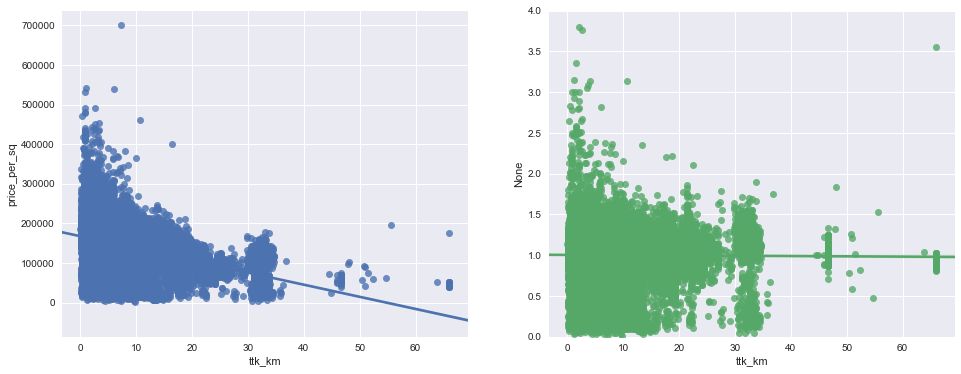

In [502]:
fig, ax = plt.subplots(1,2,figsize=[16,6])
sns.regplot(train['ttk_km'], train['price_per_sq'], ax=ax[0])
sns.regplot(train['ttk_km'], train['price_per_sq']/train['price_per_sq_sub_area'], ax=ax[1])
_ = ax[1].set_ylim(0,4)

### Garden Ring

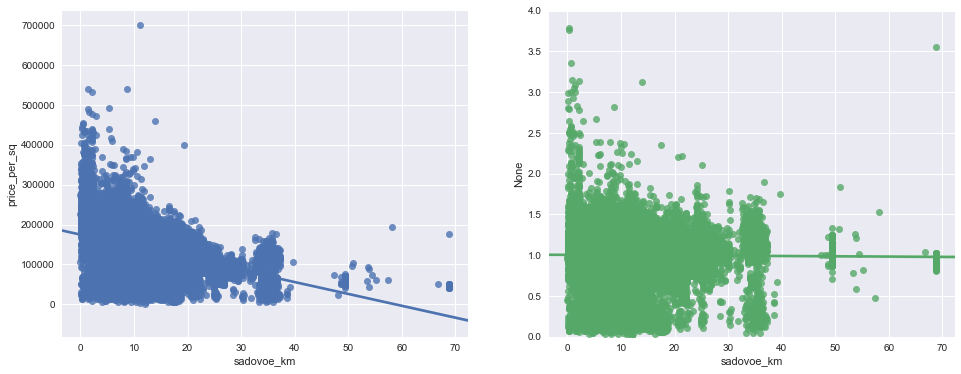

In [505]:
fig, ax = plt.subplots(1,2,figsize=[16,6])
sns.regplot(train['sadovoe_km'], train['price_per_sq'], ax=ax[0])
sns.regplot(train['sadovoe_km'], train['price_per_sq']/train['price_per_sq_sub_area'], ax=ax[1])
_ = ax[1].set_ylim(0,4)

### Subway

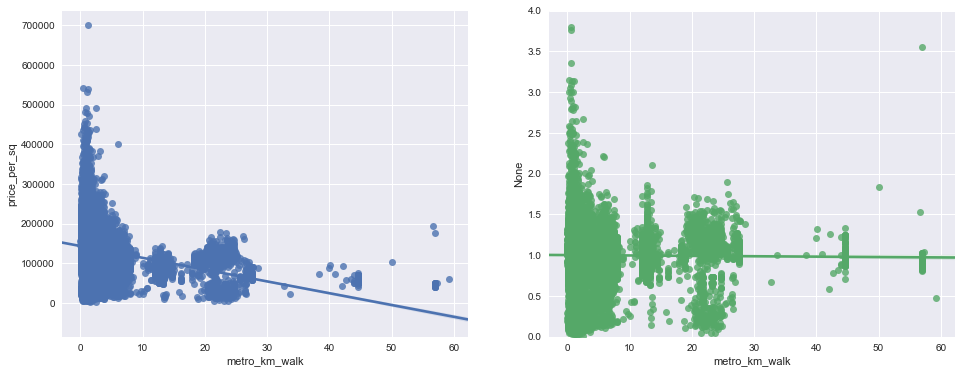

In [506]:
fig, ax = plt.subplots(1,2,figsize=[16,6])
sns.regplot(train['metro_km_walk'], train['price_per_sq'], ax=ax[0])
sns.regplot(train['metro_km_walk'], train['price_per_sq']/train['price_per_sq_sub_area'], ax=ax[1])
_ = ax[1].set_ylim(0,4)

## Kremlin

As seen in the figure, with respect to the negative slope of the regression line, the houses closer to the city center are more expensive.

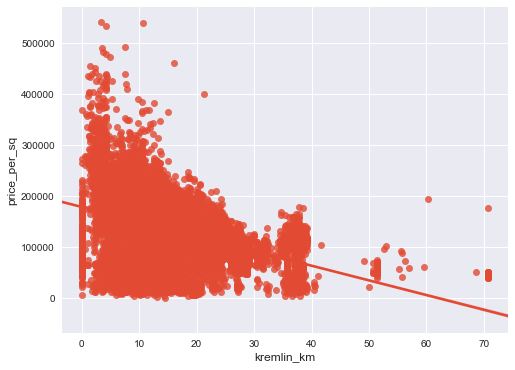

In [45]:
fig, ax = plt.subplots(figsize=[8,6])
sns.regplot(train['kremlin_km'], train['price_per_sq'])
#sns.regplot(train['kremlin_km'], train['price_per_sq']/train['price_per_sq_sub_area'], ax=ax[1])
#_ = ax[1].set_ylim(0,4)

## Healthcare

### Public Healthcare

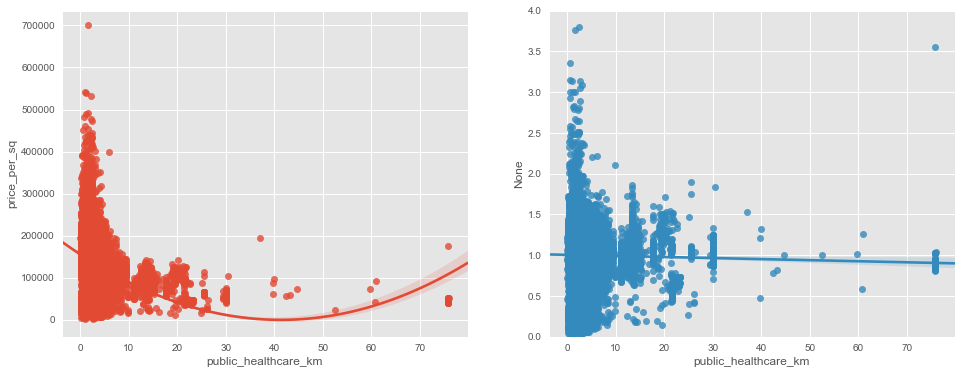

In [278]:
fig, ax = plt.subplots(1,2,figsize=[16,6])
sns.regplot(train['public_healthcare_km'], train['price_per_sq'], ax=ax[0], order=2)
sns.regplot(train['public_healthcare_km'], train['price_per_sq']/train['price_per_sq_sub_area'], ax=ax[1])
_ = ax[1].set_ylim(0,4)

### Ecology

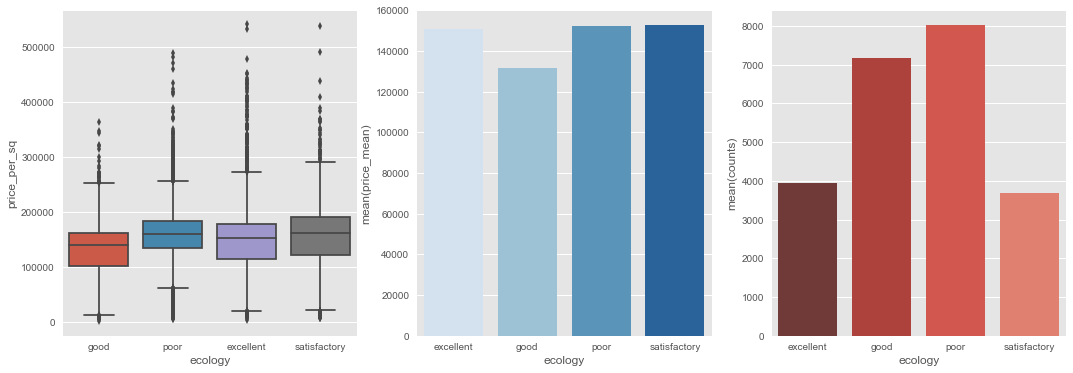

In [11]:
fig, ax = plt.subplots(1,3,figsize=[18,6])

df1 = train.groupby('ecology')[['price_per_sq']].size().reset_index().rename(columns={0:'counts'})
df2 = train.groupby('ecology')[['price_per_sq']].mean().reset_index().rename(columns={'price_per_sq':'price_mean'})
df = pd.merge(df1, df2, on='ecology')

sns.boxplot(train['ecology'], train['price_per_sq'], ax=ax[0])
sns.barplot(x='ecology', y='price_mean', data=df, palette='Blues', ax=ax[1])
sns.barplot(x='ecology', y='counts', data=df, palette='Reds_d', ax=ax[2])

### Green Zone

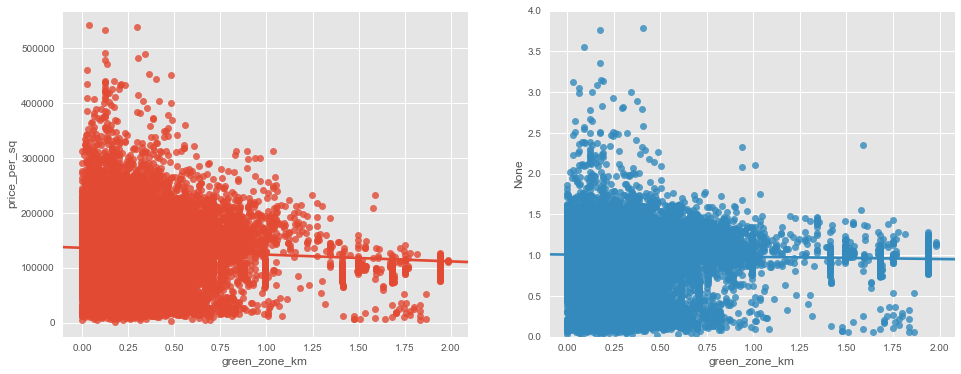

In [12]:
fig, ax = plt.subplots(1,2,figsize=[16,6])
sns.regplot(train['green_zone_km'], train['price_per_sq'], ax=ax[0])
sns.regplot(train['green_zone_km'], train['price_per_sq']/train['price_per_sq_sub_area'], ax=ax[1])
_ = ax[1].set_ylim(0,4)

### Shopping Mall

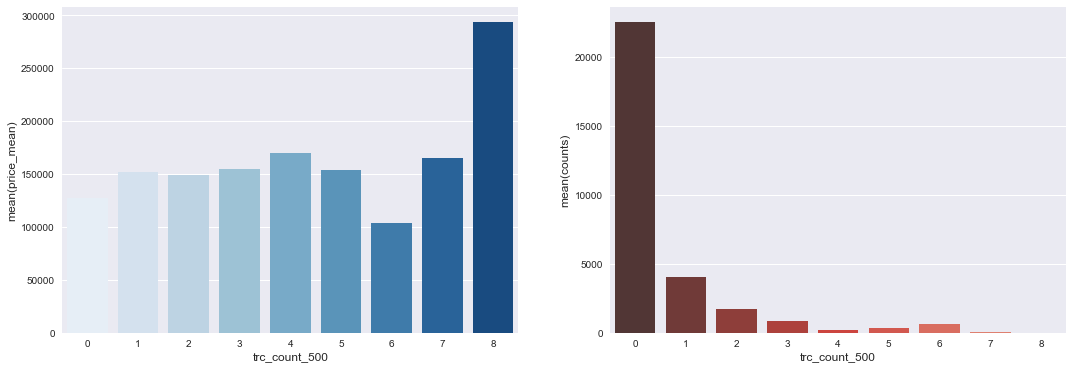

In [33]:
fig, ax = plt.subplots(1,2,figsize=[18,6])

df1 = train.groupby('trc_count_500')[['price_per_sq']].size().reset_index().rename(columns={0:'counts'})
df2 = train.groupby('trc_count_500')[['price_per_sq']].mean().reset_index().rename(columns={'price_per_sq':'price_mean'})
df = pd.merge(df1, df2, on='trc_count_500')

#sns.boxplot(train['trc_count_500'], train['price_per_sq'], ax=ax[0])
sns.barplot(x='trc_count_500', y='price_mean', data=df, palette='Blues', ax=ax[0])
sns.barplot(x='trc_count_500', y='counts', data=df, palette='Reds_d', ax=ax[1])

## Time series

one of the most useful analysis in economical data is the Time series analysis. Here we could seek the economical parameters and the market characteristics through the time. Also we can see some noable changes that coluld be related to some different happenings.

- From the first figure, it seems that, generaly, the house prices has increased most of the times, except for a period of time in ..., that it deeply decreased.

- The average of the house prices has inreased annualy. In this period the annual average growth in house prices is around 6%.

- On the other hand, in the period of 2012-2014, the Number of Transactions in the House Market has a noatable growth, 40% for 201 and 70% for 2014.

- A very interesting thing could be seen in the 4th figure, the quarterly average prices. We can see an orderly seasonal characteristics in the House prices. For 3 successive yars, reaches to its highest value in Summers, and after that it goes down. This is a very important thing that culd be used in learning the regression model.

(0, 150931.84134612279)

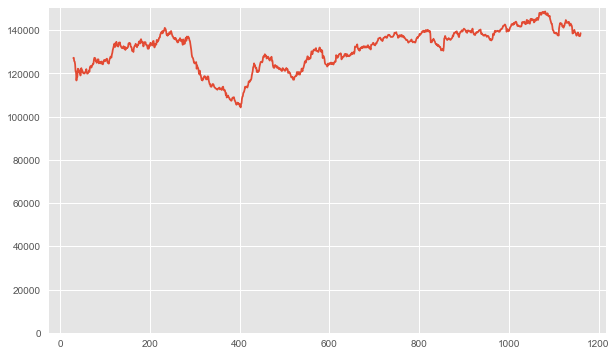

In [277]:
fig, ax = plt.subplots(figsize=(10, 6))
df = train[['timestamp', 'price_per_sq']].groupby('timestamp').mean().reset_index()
plt.plot(df.price_per_sq.rolling(window=30).mean())
plt.ylim(0,)

[<matplotlib.text.Text at 0x17722be0>, <matplotlib.text.Text at 0x177140f0>]

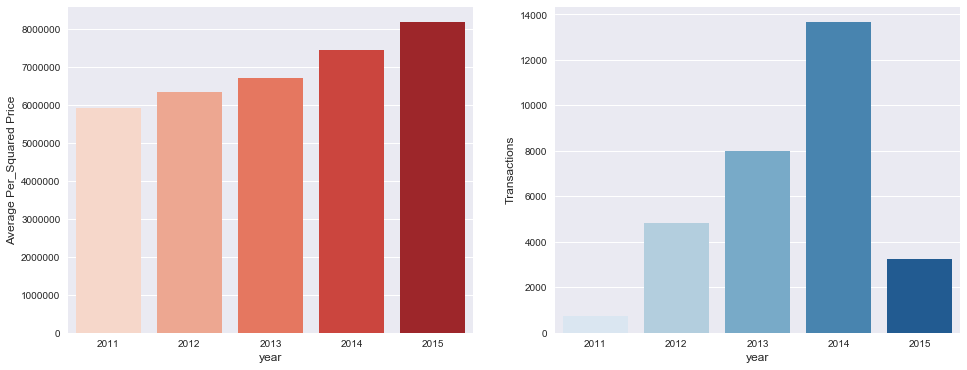

In [47]:
df1 = train.groupby(train.timestamp.dt.year).size().reset_index().rename(columns={0:'counts'})
df2 = train.groupby(train.timestamp.dt.year).mean()[['price_per_sq', 'price_doc']].reset_index()
df = pd.merge(df1, df2, on='timestamp')

fig, ax = plt.subplots(1,2,figsize=(16, 6))
sns.barplot(df.timestamp, df.price_doc, ax=ax[0], palette='Reds')
ax[0].set(xlabel='year', ylabel='Average House Price')
sns.barplot(df.timestamp, df.counts, ax=ax[1], palette='Blues')
ax[1].set(xlabel='year', ylabel='Transactions')

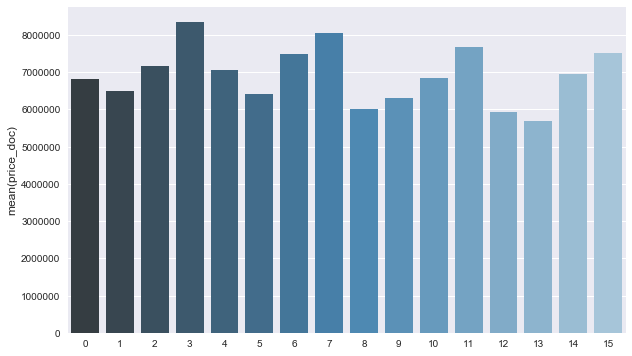

In [54]:
df = train[['timestamp', 'price_doc']]
df['year'] = df.timestamp.dt.year
df['quarter'] = df.timestamp.dt.quarter
df = df.drop('timestamp', axis=1)

df = df.groupby(['quarter', 'year']).mean().reset_index()

fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(range(len(df)), df.price_doc, palette='Blues_d')
ax.legend(bbox_to_anchor=(1, 0.6))

In [34]:
df

,quarter,year,counts
0,1,2012,1001
1,1,2013,1313
2,1,2014,3214
3,1,2015,1528
4,2,2012,956
5,2,2013,1891
6,2,2014,3699
7,2,2015,1711
8,3,2011,42
9,3,2012,1272


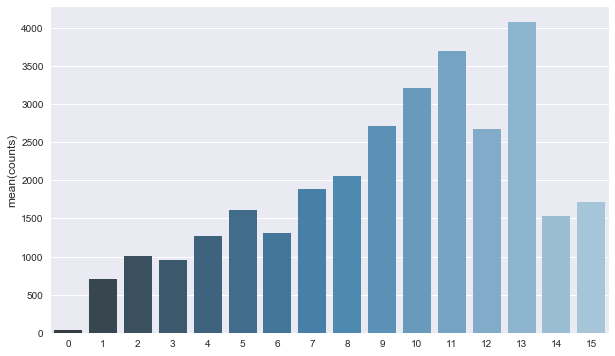

In [35]:
df = train[['timestamp', 'price_doc']]
df['year'] = df.timestamp.dt.year
df['quarter'] = df.timestamp.dt.quarter
df = df.drop('timestamp', axis=1)

df = df.groupby(['quarter', 'year']).size().reset_index().rename(columns={0:'counts'}).sort_values(by='year')

fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(range(len(df)), df.counts, palette='Blues_d')
ax.legend(bbox_to_anchor=(1, 0.6))

## Economical Parameters

There are a lot of economical parameters, that many of theme are correlated to each other, and have an effective impact on variations in markets. The most important parameters, that also people often talk about them, are the exchange rate, Inflation rate, average salary and House Funding. Here we can see the variations of these parameters over the time and also their correlations with average of the house prices.

- The exchange rate USD-RUBL has increased gently for a long time, until 2015 that it abruptly jumped up around 100% in a period of 3 months. This might be related to EU and US sanctions against Russia. Despite the USD-RUBL exchange rate has a positive relation on house prices, however, we don't see an abruption in the sale prices.

- Inflation rate is one the most important parameter that prices are expected to change with. It can also show economical stability during the time. As seen in the figure, the Inflation growth rate has been arount 6.7% for more than 3 years, until 2015, that increases up to 30% for a period of 4 years. However, it returned back to the 6% rate after 4 months.

- The average salary had been growing for 3 years with around 10% annualy. However we see that the average salary growth is only 5% in 2015. 

- Housing Funds are mostly used to shake the house maket. This could increase the number of transactions. Maybe this is why a big jump of Housing Funds has been occured in 2012.

In [27]:
df_day = train.groupby('timestamp')\
    [['usdrub', 'salary', 'cpi', 'fixed_basket', 'housing_fund_sqm', 'price_doc', 'price_per_sq', 'price_per_sq_sub_area']].\
    mean().reset_index().sort_values(by='timestamp').\
    rename(columns={'price_doc':'price_doc_mean', 
                    'price_per_sq':'price_per_sq_mean', 
                    'price_per_sq_sub_area':'price_per_sq_region_mean'})

df_day = pd.merge(df_day, train.groupby('timestamp')[['price_doc', 'price_per_sq', 'price_per_sq_sub_area']].\
              std().reset_index().sort_values(by='timestamp'), on='timestamp').\
              rename(columns={'price_doc':'price_doc_std', 
                              'price_per_sq':'price_per_sq_std', 
                              'price_per_sq_sub_area':'price_per_sq_region_std'})
    
df_day = pd.merge(df_day, train.groupby('timestamp').size().reset_index().sort_values(by='timestamp'), on='timestamp').\
        rename(columns={0:'counts'})

df_day.fillna(0, inplace=True)

#df_day

In [6]:
df_year_month = train.groupby(train.timestamp.dt.to_period('M'))\
    [['usdrub', 'salary', 'cpi', 'fixed_basket', 'housing_fund_sqm', 'price_doc', 'price_per_sq', 'price_per_sq_sub_area']].\
    mean().reset_index().sort_values(by='timestamp').\
    rename(columns={'price_doc':'price_doc_mean', 
                    'price_per_sq':'price_per_sq_mean', 
                    'price_per_sq_sub_area':'price_per_sq_region_mean'})

df_year_month = pd.merge(df_year_month, train.groupby(train.timestamp.dt.to_period('M'))
                         [['price_doc', 'price_per_sq', 'price_per_sq_sub_area']].\
                         std().reset_index().sort_values(by='timestamp'), on='timestamp').\
                         rename(columns={'price_doc':'price_doc_std', 
                                         'price_per_sq':'price_per_sq_std', 
                                         'price_per_sq_sub_area':'price_per_sq_region_std'})
    
df_year_month = pd.merge(df_year_month, train.groupby(train.timestamp.dt.to_period('M')).size().\
                         reset_index().sort_values(by='timestamp'), on='timestamp').\
                         rename(columns={0:'counts'})

df_year_month.fillna(0, inplace=True)

#df_year_month

In [7]:
df_month = train.groupby(train.timestamp.dt.month)\
    [['usdrub', 'salary', 'cpi', 'fixed_basket', 'housing_fund_sqm', 'price_doc', 'price_per_sq', 'price_per_sq_sub_area']].\
    mean().reset_index().sort_values(by='timestamp').\
    rename(columns={'price_doc':'price_doc_mean', 
                    'price_per_sq':'price_per_sq_mean', 
                    'price_per_sq_sub_area':'price_per_sq_region_mean'})

df_month = pd.merge(df_month, train.groupby(train.timestamp.dt.month)\
                    [['price_doc', 'price_per_sq', 'price_per_sq_sub_area']].\
                    std().reset_index().sort_values(by='timestamp'), on='timestamp').\
                    rename(columns={'price_doc':'price_doc_std', 
                                    'price_per_sq':'price_per_sq_std', 
                                    'price_per_sq_sub_area':'price_per_sq_region_std'})
    
df_month = pd.merge(df_month, train.groupby(train.timestamp.dt.month).size().\
                    reset_index().sort_values(by='timestamp'), on='timestamp').\
                    rename(columns={0:'counts'})

df_month.fillna(0, inplace=True)

#df_month

In [8]:
df_year_quarter = train.groupby(train.timestamp.dt.to_period('Q'))\
    [['usdrub', 'salary', 'cpi', 'fixed_basket', 'housing_fund_sqm', 'price_doc', 'price_per_sq', 'price_per_sq_sub_area']].\
    mean().reset_index().sort_values(by='timestamp').\
    rename(columns={'price_doc':'price_doc_mean', 
                    'price_per_sq':'price_per_sq_mean', 
                    'price_per_sq_sub_area':'price_per_sq_region_mean'})

df_year_quarter = pd.merge(df_year_quarter, train.groupby(train.timestamp.dt.to_period('Q'))\
                           [['price_doc', 'price_per_sq', 'price_per_sq_sub_area']].\
                           std().reset_index().sort_values(by='timestamp'), on='timestamp').\
                           rename(columns={'price_doc':'price_doc_std', 
                                           'price_per_sq':'price_per_sq_std', 
                                           'price_per_sq_sub_area':'price_per_sq_region_std'})
    
df_year_quarter = pd.merge(df_year_quarter, train.groupby(train.timestamp.dt.to_period('Q')).size().\
                         reset_index().sort_values(by='timestamp'), on='timestamp').\
                         rename(columns={0:'counts'})

df_year_quarter.fillna(0, inplace=True)

#df_year_quarter

In [9]:
df_quarter = train.groupby(train.timestamp.dt.quarter)\
    [['usdrub', 'salary', 'cpi', 'fixed_basket', 'housing_fund_sqm', 'price_doc', 'price_per_sq', 'price_per_sq_sub_area']].\
    mean().reset_index().sort_values(by='timestamp').\
    rename(columns={'price_doc':'price_doc_mean', 
                    'price_per_sq':'price_per_sq_mean', 
                    'price_per_sq_sub_area':'price_per_sq_region_mean'})

df_quarter = pd.merge(df_quarter, train.groupby(train.timestamp.dt.quarter)
                      [['price_doc', 'price_per_sq', 'price_per_sq_sub_area']].\
                      std().reset_index().sort_values(by='timestamp'), on='timestamp').\
                      rename(columns={'price_doc':'price_doc_std', 
                                      'price_per_sq':'price_per_sq_std', 
                                      'price_per_sq_sub_area':'price_per_sq_region_std'})
    
df_quarter = pd.merge(df_quarter, train.groupby(train.timestamp.dt.quarter).size().\
                      reset_index().sort_values(by='timestamp'), on='timestamp').\
                      rename(columns={0:'counts'})

df_quarter.fillna(0, inplace=True)

#df_quarter

### USD-RUBL

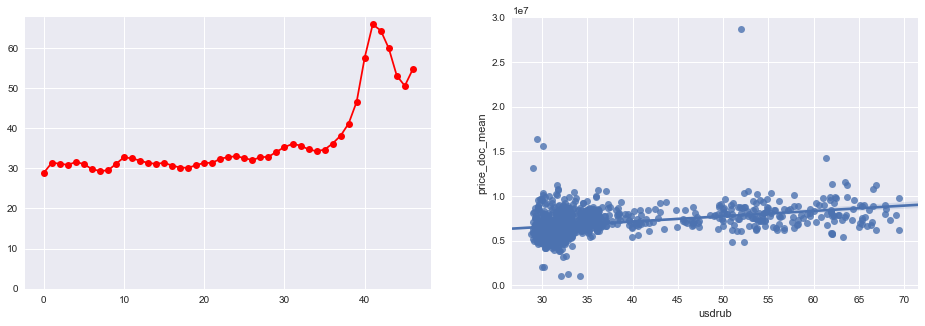

In [106]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(1,2,figsize=[16,5])
ax[0].plot(df_year_month['usdrub'], marker='o', color='r')
ax[0].set_ylim(0)
sns.regplot(df_day['usdrub'], df_day['price_doc_mean'], ax=ax[1])

### CPI

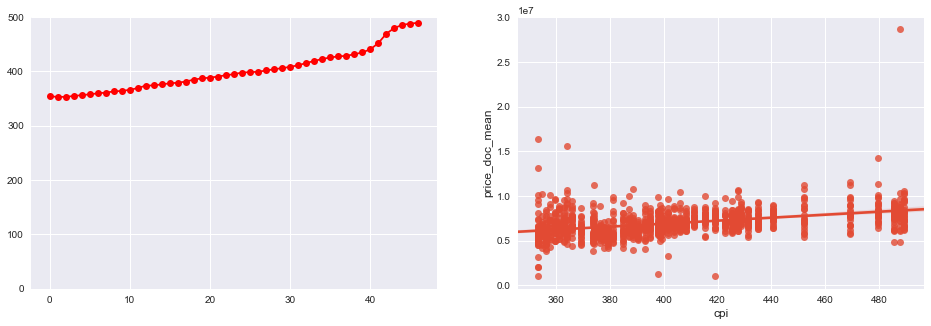

In [10]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(1,2,figsize=[16,5])
ax[0].plot(df_year_month['cpi'], marker='o', color='r')
ax[0].set_ylim(0,500)
sns.regplot(df_day['cpi'], df_day['price_doc_mean'], ax=ax[1])

### Salary

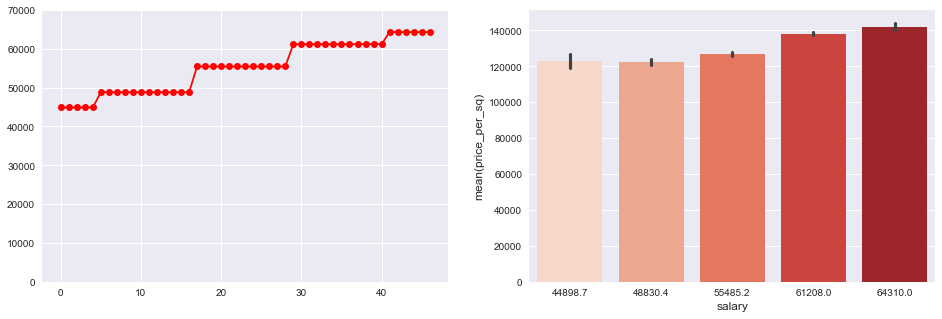

In [15]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(1,2,figsize=[16,5])
ax[0].plot(df_year_month['salary'], marker='o', color='r')
ax[0].set_ylim(0,70000)
sns.barplot(train['salary'], train['price_per_sq'], palette='Reds')

### Housing Fund

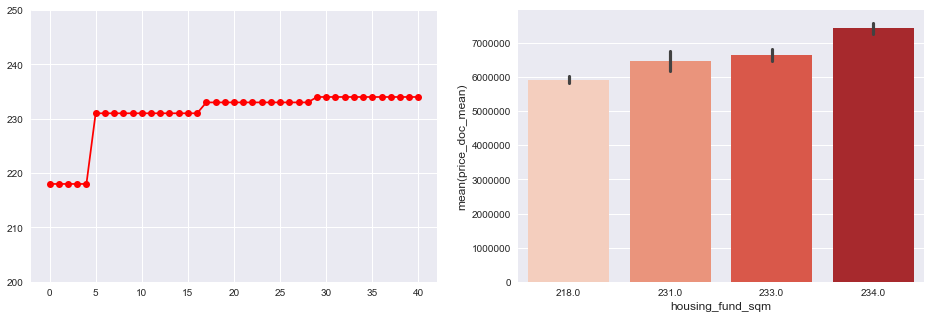

In [36]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(1,2,figsize=[16,5])
ax[0].plot(df_year_month[df_year_month['housing_fund_sqm']>0]['housing_fund_sqm'], marker='o', color='r')
ax[0].set_ylim(200,250)
sns.barplot(df_year_month[df_year_month['housing_fund_sqm']>0]['housing_fund_sqm'], 
            df_year_month[df_year_month['housing_fund_sqm']>0]['price_doc_mean'], palette='Reds', ax=ax[1])

## Correlations

The figure below shows the correlations between these parameters using color coding. We can find groups of features most correlated with each other, for example, we see that the transportation features are highly correlated to each other, or also we can see this propety for economical features.

In the second figure, the correlation between average per squared price and other parameters is shown. We can find most correlated features, positive or negative relation, to the sale prices. For instance, age of the house, state, region and transportation facilities have an impact on prices. However, floor of the house and nearing to the church have almost no effect.

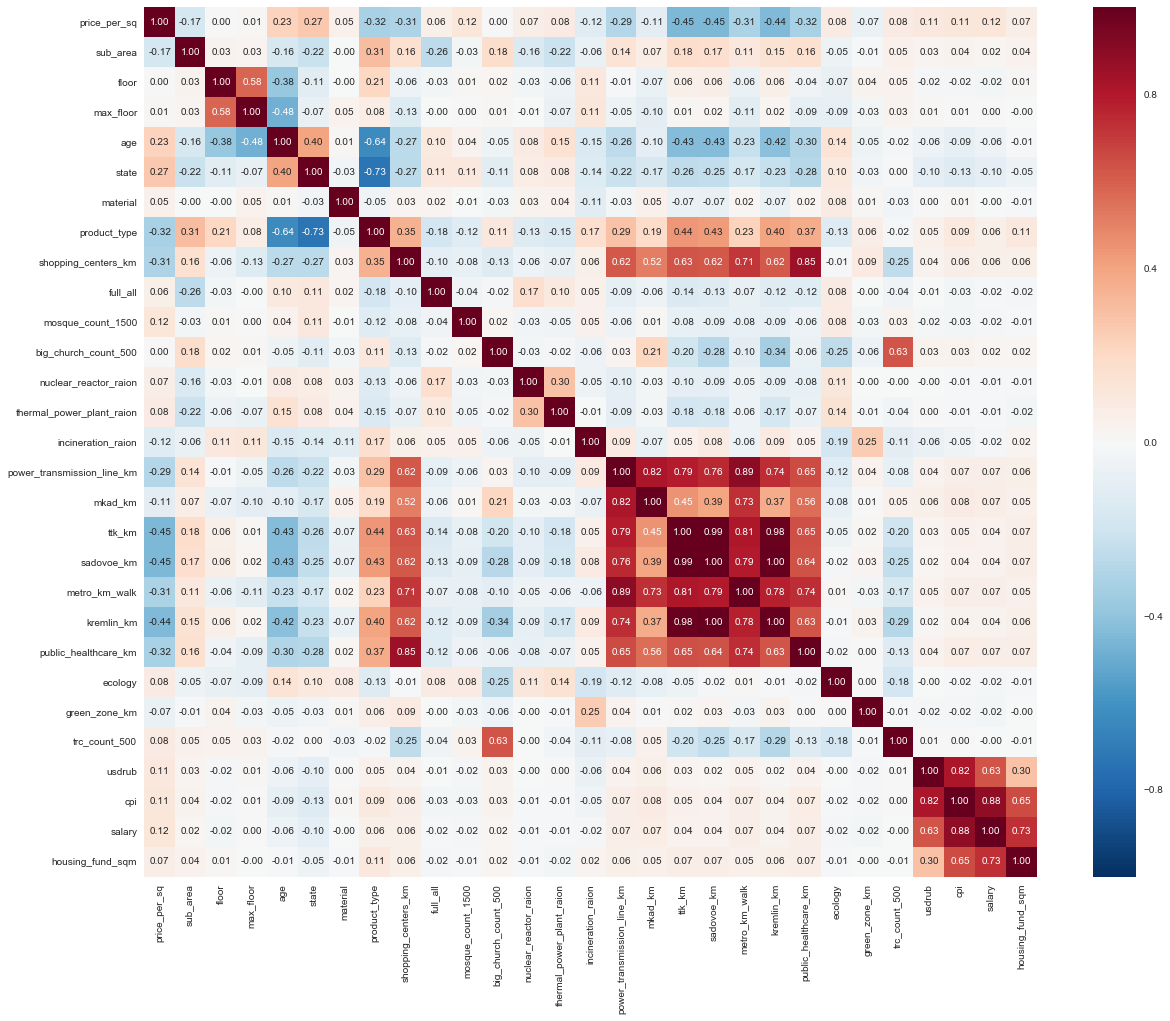

In [38]:
corr_cols = ['price_per_sq', 'sub_area', 'floor', 'max_floor', 'age', 'state', 'material', 'product_type',
             'shopping_centers_km', 'full_all', 'mosque_count_1500', 'big_church_count_500', 'nuclear_reactor_raion',
             'thermal_power_plant_raion', 'incineration_raion', 'power_transmission_line_km', 'mkad_km', 'ttk_km',
             'sadovoe_km', 'metro_km_walk', 'kremlin_km', 'public_healthcare_km', 'ecology', 'green_zone_km',
             'trc_count_500', 'usdrub', 'cpi', 'salary', 'housing_fund_sqm']
df = train[corr_cols]
for c in df.columns:
    if df[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df[c].values)) 
        df[c] = lbl.transform(list(df[c].values))

#fig, ax = plt.subplots(figsize=[20,16])
corrs = df[corr_cols].corr()
mask = np.zeros_like(corrs, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=[20,16])
sns.heatmap(corrs, annot=True, fmt=".2f")

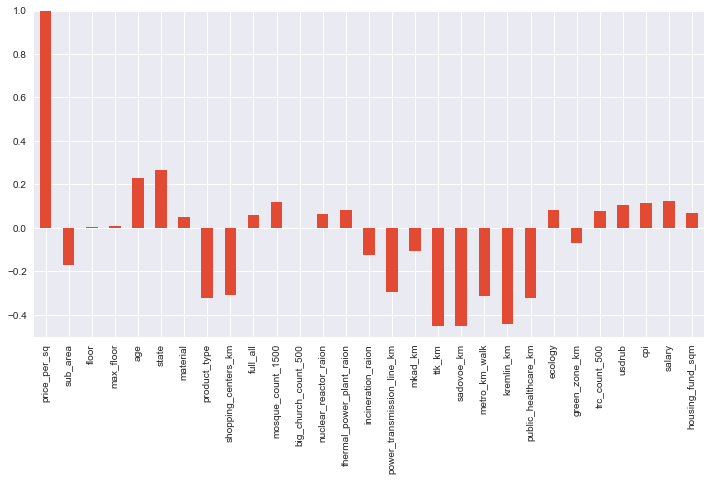

In [39]:
corrs = df[corr_cols].corr()

fig, ax = plt.subplots(figsize=[12,6])
corrs.price_per_sq.plot.bar()
_ = ax.set_ylim(-0.5,1)

## Important Features

There is a vey useful method implemented in algorithms, is feature_importance. It shows the most important features in data based their positive effect on some internal scores such as Gini Index measured during the Learning process. Here I used the Extreme Gradient boosting model (xgboost), and the 50 most important features are shown in the figure below with respect to their scores.

Here, we can see that, total and life area of a house, floor, state and age are the most important fetures. This is not an absolute measurement, as the colinearity between different parameters especially in high dimensional space, might be concluded to some weird results. As an instance we can see the Kindergartten distance as a very important feature.

<function matplotlib.pyplot.show>

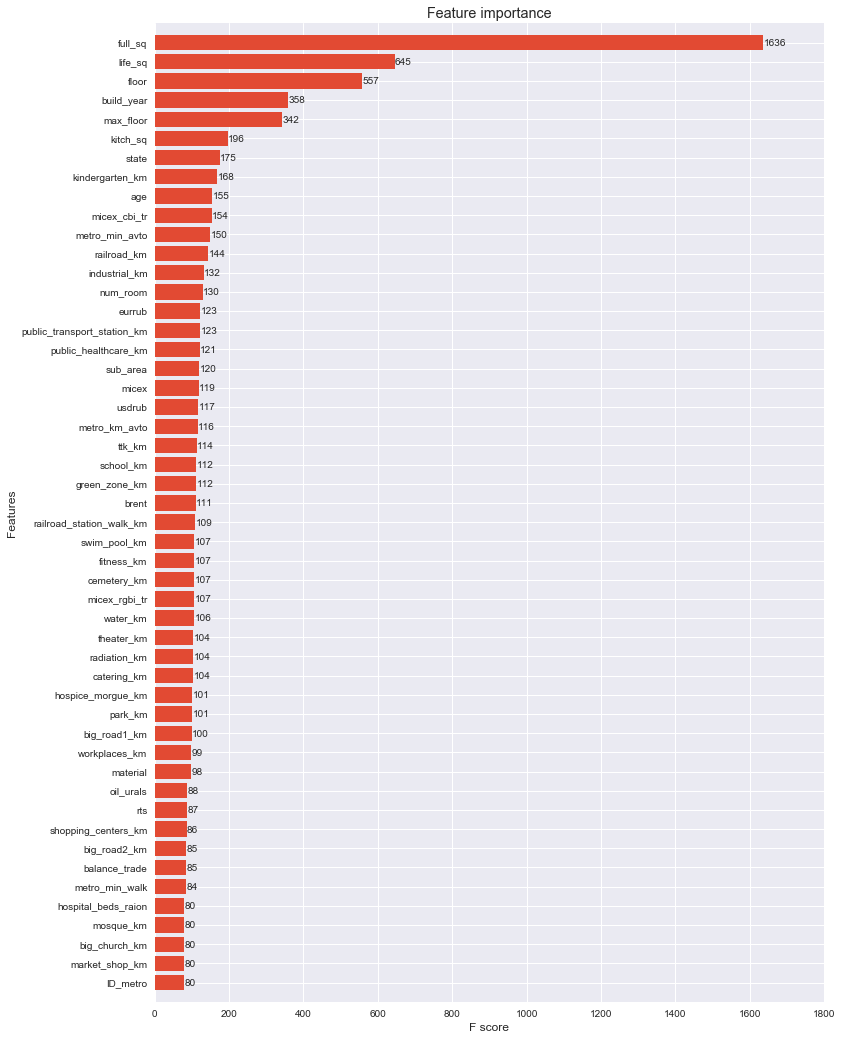

In [59]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

X_train = train.drop(['timestamp', 'id', 'price_doc', 'price_per_sq', 'price_per_sq_sub_area'], axis=1)
y_train = train['price_doc']
cols = X_train.columns
for c in X_train.columns:
    if X_train[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[c].values)) 
        X_train[c] = lbl.transform(list(X_train[c].values))
        
dtrain = xgb.DMatrix(X_train, y_train)

model = xgb.train(dict(xgb_params,silent=0),dtrain,num_boost_round=100)

fig,ax=plt.subplots(figsize = (12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show